# Classical simulations using Exact Diagonalization

In [34]:
import numpy as np
from scipy.sparse import linalg
from scipy.sparse.linalg import LinearOperator, eigsh
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
'''
Initial state preparation
'''

def get_psi_zero(N, initial_state_type):
    psi_zero = np.ones(1)

    spin_up = np.array([[1],[0]])
    spin_down = np.array([[0],[1]])

    if initial_state_type == 'domain_wall':
        for i in range(N):
            if i < N//2:
                psi_zero = np.kron(psi_zero, spin_down)
            else:
                psi_zero = np.kron(psi_zero, spin_up) 

    elif initial_state_type == 'neel':
        for i in range(N):
            if i%2 == 0:
                psi_zero = np.kron(psi_zero, spin_down)
            else:
                psi_zero = np.kron(psi_zero, spin_up)

    else:
        print("Initial state type error")
        
    return psi_zero

def get_2D_psi_zero(M, N, initial_state_type):
    psi_zero = np.ones(1)

    spin_up = np.array([[1],[0]])
    spin_down = np.array([[0],[1]])

    if initial_state_type == 'domain_wall':
        for i in range(M):
            for j in range(N):
                if j < N//2:
                    psi_zero = np.kron(psi_zero, spin_down)
                else:
                    psi_zero = np.kron(psi_zero, spin_up) 

    elif initial_state_type == 'neel':
        for i in range(M):
            for j in range(N):
                if (i+j)%2 == 0:
                    psi_zero = np.kron(psi_zero, spin_down)
                else:
                    psi_zero = np.kron(psi_zero, spin_up)

    else:
        print("Initial state type error")
        
    return psi_zero

In [36]:
'''
Local Hamiltonian
'''

def calc_local_hamiltonian(x, N, ind1_, ind2_, h_type):
    sX = np.array([[0, 1.0], [1.0, 0]])
    sY = np.array([[0, -1.0j], [1.0j, 0]])
    sZ = np.array([[1.0, 0], [0, -1.0]])
    sI = np.array([[1.0, 0], [0, 1.0]])
    
    if (h_type == 'Z_to_ind1'):
        gate = sZ
        res = np.tensordot(gate,
                           np.reshape(x, (2**(ind1_), 2, 2**(N-ind1_-1))),
                           axes=[[1], [1]]).transpose(1, 0, 2).reshape(2**N)
        
        return res
    
    if (h_type == 'X'):
        gate = sX
    elif (h_type == 'Y'):
        gate = sY
    elif (h_type == 'Z'):
        gate = sZ
    elif (h_type == 'I'):
        gate = sI
    else:
        print("Gate type error")
        return
    
    if (ind1_ > ind2_):
        ind1 = ind2_
        ind2 = ind1_
    else:
        ind1 = ind1_
        ind2 = ind2_
        
    gate_2 = np.tensordot(gate, gate, axes=0)
    res = np.tensordot(gate_2,
                       np.reshape(x, (2**(ind1), 2, 2**(ind2-ind1-1), 2, 2**(N-ind2-1))),
                       axes=[[1,3], [1,3]]).transpose(2, 0, 3, 1, 4).reshape(2**N)
        
    return res

In [37]:
'''
Hamiltonian
'''

def apply_hamiltonian(x, N, U, h, is_disordered):
    
    res = np.zeros(2**N)
    
    # XX-chain part
    for j in range(N-1):
        res = np.add(res, calc_local_hamiltonian(x, N, j, j+1, 'X'))
        res = np.add(res, calc_local_hamiltonian(x, N, j, j+1, 'Y'))

    # Z part
    for j in range(N-1):
        res = np.add(res, U * calc_local_hamiltonian(x, N, j, j+1, 'Z'))

    # Linear potential part
    if is_disordered:
        h_list = list(2 * h * (random.random()-0.5) for j in range(N))
        
        for j in range(N):
            res = np.add(res, h_list[j] * calc_local_hamiltonian(x, N, j, 0, 'Z_to_ind1'))
            
    return res

In [38]:
'''
Hamiltonian
'''

def apply_hamiltonian_nnn(x, N, U, h, is_disordered):
    
    res = np.zeros(2**N)
    
    # XX-chain part
    for j in range(N-1):
        res = np.add(res, calc_local_hamiltonian(x, N, j, j+1, 'X'))
        res = np.add(res, calc_local_hamiltonian(x, N, j, j+1, 'Y'))

    # Z part
    for j in range(N-1):
        res = np.add(res, U * calc_local_hamiltonian(x, N, j, j+1, 'Z'))
        
    # XX-chain part
    for j in range(N-2):
        res = np.add(res, calc_local_hamiltonian(x, N, j, j+2, 'X'))
        res = np.add(res, calc_local_hamiltonian(x, N, j, j+2, 'Y'))
        
    # Z part
    for j in range(N-2):
        res = np.add(res, U * calc_local_hamiltonian(x, N, j, j+2, 'Z'))

    # Linear potential part
    if is_disordered:
        h_list = list(2 * h * (random.random()-0.5) for j in range(N))
        
        for j in range(N):
            res = np.add(res, h_list[j] * calc_local_hamiltonian(x, N, j, 0, 'Z_to_ind1'))
            
    return res

In [39]:
'''
2D Hamiltonian
'''

# M rows and N columns
def apply_2D_hamiltonian(x, M, N, U, h, is_disordered):
    
    res = np.zeros(2**(N*M))
    
    # XX-chain part
    for i in range(M):
        for j in range(N-1):
            res = np.add(res, calc_local_hamiltonian(x, M*N, N*i+j, N*i+j+1, 'X'))
            res = np.add(res, calc_local_hamiltonian(x, M*N, N*i+j, N*i+j+1, 'Y'))

    # Z part
    for i in range(M):
        for j in range(N-1):
            res = np.add(res, U * calc_local_hamiltonian(x, M*N, N*i+j, N*i+j+1, 'Z'))

    # XX-chain part
    for j in range(N):
        for i in range(M-1):
            res = np.add(res, calc_local_hamiltonian(x, M*N, N*i+j, N*(i+1)+j, 'X'))
            res = np.add(res, calc_local_hamiltonian(x, M*N, N*i+j, N*(i+1)+j, 'Y'))

    # Z part
    for j in range(N):
        for i in range(M-1):
            res = np.add(res, U * calc_local_hamiltonian(x, M*N, N*i+j, N*(i+1)+j, 'Z'))
            
    # Linear potential part
    if is_disordered:
        h_list = list(2 * h * (random.random()-0.5) for j in range(M*N))
        
        for j in range(N):
            res = np.add(res, h_list[j] * calc_local_hamiltonian(x, M*N, j, 0, 'Z_to_ind1'))
            
    return res

In [62]:
'''
Measurements
'''

def meas_sig_z(N, psi, n: int):    
    x = psi.reshape(2**N)

    res = np.dot(x.conj(), calc_local_hamiltonian(x, N, n, 0, 'Z_to_ind1'))
        
    return np.real(res)

def meas_2D_sig_z(M, N, psi, m:int, n:int):    
    x = psi.reshape(2**(N*M))

    res = np.dot(x.conj(), calc_local_hamiltonian(x, N*M, m*N+n, 0, 'Z_to_ind1'))
        
    return np.real(res)

def meas_n_half(N, psi, k=0):
    res = 0
    
    for i in range(N//2):
        res += (meas_sig_z(N, psi, i)+1)/2
        
    if (k == 1):
        for i in range(4):
            for j in range(2):
                res += (meas_sig_z(N, psi, 4*i+j)+1)/2
        
    return res

def meas_cor(N, psi, n: int):
    x = psi.reshape(2**N)
    
    psi1 = calc_local_hamiltonian(x, N, 0, 0, 'Z_to_ind1')
    psi2 = calc_local_hamiltonian(psi1, N, n, 0, 'Z_to_ind1')
    
    res = np.dot(x.conj(), psi2) - meas_sig_z(N, psi, 0) * meas_sig_z(N, psi, n)
    
    return np.abs(res)

def meas_2D_cor(M, N, psi, m: int, n: int):
    x = psi.reshape(2**(M*N))
    
    psi1 = calc_local_hamiltonian(x, N*M, 0, 0, 'Z_to_ind1')
    psi2 = calc_local_hamiltonian(psi1, N*M, m*N+n, 0, 'Z_to_ind1')
    
    res = np.dot(x.conj(), psi2) - meas_sig_z(N*M, psi, 0) * meas_sig_z(N*M, psi, m*N+n)
    
    return np.abs(res)

In [51]:
import quspin.tools.lanczos as lancozs
import random

In [52]:
def draw(N:int, U_, h_, draw_type, dt_, t_, to_image):
    title_params = draw_type.copy()
    if title_params[2] == 'M_all':
        title_params[2] == 'M'
    title = f'{title_params[2]} ({title_params[0]} {title_params[1]} {title_params[3]} Size={N})\n(Classical Simulation)'
    
    colors = ['r', 'g', 'b', 'y', 'm']
    
    def hamiltonian(x):
        if draw_type[0] == '1Dnn':
            return apply_hamiltonian(x, N, U, h, is_disordered)
        elif draw_type[0] == '1Dnnn':
            return apply_hamiltonian_nnn(x, N, U, h, is_disordered)
        elif draw_type[0] == '2Dnn':
            return apply_2D_hamiltonian(x, N, N, U, h, is_disordered)
    
    if draw_type[3] == 'N':
        initial_state_type = 'neel'
    elif draw_type[3] == 'DW':
        initial_state_type = 'domain_wall'
    
    # 2D는 여기서 먼저 처리함.
    if draw_type[0] == '2Dnn':
        M = N*N
        
        if draw_type[1] == 'XX':
            U = 0
            h = 0
            is_disordered = False

            if draw_type[2] == 'M':
                H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    result.append(meas_sig_z(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), M-1))
                plt.plot(t, result, '-o')
                plt.xlabel('$Jt$')
                plt.ylabel('$\sigma_{z}$')

            if draw_type[2] == 'Nhalf':
                H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    result.append(meas_n_half(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), k=1))
                plt.plot(t, result, '-o')
                plt.xlabel('$Jt$')


            if draw_type[2] == 'Corr':
                H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(M):
                        result.append(meas_cor(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), n))
                result_array = np.reshape(result, (len(t), M))

                plt.imshow(result_array, extent=[0, M-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')


            if draw_type[2] == 'M_all':
                H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(M):
                        result.append(meas_sig_z(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), n))
                result_array = np.reshape(result, (len(t), M))

                plt.imshow(result_array, extent=[0, M-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=-1, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')


        elif draw_type[1] == 'd XX':
            U = 0
            h_list = [0, 0.5, 1.0, 1.5, 2.0]
            is_disordered = True

            if draw_type[2] == 'M':
                for i in range(len(h_list)):
                    h = h_list[i]
                    H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                    psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                    E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                    t = np.arange(0, t_, dt_)
                    result = []
                    for time in t:
                        result.append(meas_sig_z(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), M-1))
                    plt.plot(t, result, f'{colors[i]}-o', label=f'h={h}')
                plt.legend()
                plt.xlabel('$Jt$')
                plt.ylabel('$\sigma_{z}$')

            if draw_type[2] == 'Nhalf':
                for i in range(len(h_list)):
                    h = h_list[i]
                    H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                    psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                    E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                    t = np.arange(0, t_, dt_)
                    result = []
                    for time in t:
                        result.append(meas_n_half(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), k=1))
                    plt.plot(t, result, f'{colors[i]}-o', label=f'h={h}')
                plt.legend()
                plt.xlabel('$Jt$')

            if draw_type[2] == 'Corr':
                h = h_
                title = f'{title_params[2]} ({title_params[0]} {title_params[1]} {title_params[3]} Size={N} h={h})\n(Classical Simulation)'
                H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(M):
                        result.append(meas_cor(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), n))
                result_array = np.reshape(result, (len(t), M))

                plt.imshow(result_array, extent=[0, M-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')

            if draw_type[2] == 'M_all':
                h = h_
                title = f'{title_params[2]} ({title_params[0]} {title_params[1]} {title_params[3]} Size={N} h={h})\n(Classical Simulation)'
                H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(M):
                        result.append(meas_sig_z(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), n))
                result_array = np.reshape(result, (len(t), M))

                plt.imshow(result_array, extent=[0, M-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=-1, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')


        elif draw_type[1] == 'XXZ':
            U_list = [0, 0.5, 1.0, 1.5, 2.0]
            h = 0
            is_disordered = False

            if draw_type[2] == 'M':
                for i in range(len(U_list)):
                    U = U_list[i]
                    H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                    psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                    E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                    t = np.arange(0, t_, dt_)
                    result = []
                    for time in t:
                        result.append(meas_sig_z(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), M-1))
                    plt.plot(t, result, f'{colors[i]}-o', label=f'U={U}')
                plt.legend()
                plt.xlabel('$Jt$')
                plt.ylabel('$\sigma_{z}$')

            if draw_type[2] == 'Nhalf':
                for i in range(len(U_list)):
                    U = U_list[i]
                    H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                    psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                    E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                    t = np.arange(0, t_, dt_)
                    result = []
                    for time in t:
                        result.append(meas_n_half(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), k=1))
                    plt.plot(t, result, f'{colors[i]}-o', label=f'U={U}')
                plt.legend()
                plt.xlabel('$Jt$')

            if draw_type[2] == 'Corr':
                U = U_
                title = f'{title_params[2]} ({title_params[0]} {title_params[1]} {title_params[3]} Size={N} U={U})\n(Classical Simulation)'
                H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(M):
                        result.append(meas_cor(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), n))
                result_array = np.reshape(result, (len(t), M))

                plt.imshow(result_array, extent=[0, M-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')

            if draw_type[2] == 'M_all':
                U = U_
                title = f'{title_params[2]} ({title_params[0]} {title_params[1]} {title_params[3]} Size={N} U={U})\n(Classical Simulation)'
                H = LinearOperator((2**M, 2**M), matvec=hamiltonian)
                psi_zero = get_2D_psi_zero(N, N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**M), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(M):
                        result.append(meas_sig_z(M, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**M, 1), n))
                result_array = np.reshape(result, (len(t), M))

                plt.imshow(result_array, extent=[0, M-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=-1, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')
        
        
    
    # 여기서부터 1D 모든 모델
    else:
        if draw_type[1] == 'XX':
            U = 0
            h = 0
            is_disordered = False

            if draw_type[2] == 'M':
                H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                psi_zero = get_psi_zero(N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    result.append(meas_sig_z(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1), N-1))
                plt.plot(t, result, f'-o')
                plt.xlabel('$Jt$')
                plt.ylabel('$\sigma_{z}$')

            if draw_type[2] == 'Nhalf':
                H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                psi_zero = get_psi_zero(N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    result.append(meas_n_half(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1)))
                plt.plot(t, result, '-o')
                plt.xlabel('$Jt$')


            if draw_type[2] == 'Corr':
                H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                psi_zero = get_psi_zero(N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(N):
                        result.append(meas_cor(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1), n))
                result_array = np.reshape(result, (len(t), N))

                plt.imshow(result_array, extent=[0, N-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')


            if draw_type[2] == 'M_all':
                H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                psi_zero = get_psi_zero(N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(N):
                        result.append(meas_sig_z(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1), n))
                result_array = np.reshape(result, (len(t), N))

                plt.imshow(result_array, extent=[0, N-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=-1, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')


        elif draw_type[1] == 'd XX':
            U = 0
            h_list = [0, 0.5, 1.0, 1.5, 2.0]
            is_disordered = True

            if draw_type[2] == 'M':
                for i in range(len(h_list)):
                    h = h_list[i]
                    H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                    psi_zero = get_psi_zero(N, initial_state_type)
                    E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                    t = np.arange(0, t_, dt_)
                    result = []
                    for time in t:
                        result.append(meas_sig_z(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1), N-1))
                    plt.plot(t, result, f'{colors[i]}-o', label=f'h={h}')
                plt.legend()
                plt.xlabel('$Jt$')
                plt.ylabel('$\sigma_{z}$')

            if draw_type[2] == 'Nhalf':
                for i in range(len(h_list)):
                    h = h_list[i]
                    H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                    psi_zero = get_psi_zero(N, initial_state_type)
                    E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                    t = np.arange(0, t_, dt_)
                    result = []
                    for time in t:
                        result.append(meas_n_half(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1)))
                    plt.plot(t, result, f'{colors[i]}-o', label=f'h={h}')
                plt.legend()
                plt.xlabel('$Jt$')

            if draw_type[2] == 'Corr':
                h = h_
                title = f'{title_params[2]} ({title_params[0]} {title_params[1]} {title_params[3]} Size={N} h={h})\n(Classical Simulation)'
                H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                psi_zero = get_psi_zero(N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(N):
                        result.append(meas_cor(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1), n))
                result_array = np.reshape(result, (len(t), N))

                plt.imshow(result_array, extent=[0, N-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')

            if draw_type[2] == 'M_all':
                h = h_
                title = f'{title_params[2]} ({title_params[0]} {title_params[1]} {title_params[3]} Size={N} h={h})\n(Classical Simulation)'
                H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                psi_zero = get_psi_zero(N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(N):
                        result.append(meas_sig_z(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1), n))
                result_array = np.reshape(result, (len(t), N))

                plt.imshow(result_array, extent=[0, N-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=-1, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')


        elif draw_type[1] == 'XXZ':
            U_list = [0, 0.5, 1.0, 1.5, 2.0]
            h = 0
            is_disordered = False

            if draw_type[2] == 'M':
                for i in range(len(U_list)):
                    U = U_list[i]
                    H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                    psi_zero = get_psi_zero(N, initial_state_type)
                    E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                    t = np.arange(0, t_, dt_)
                    result = []
                    for time in t:
                        result.append(meas_sig_z(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1), N-1))
                    plt.plot(t, result, f'{colors[i]}-o', label=f'U={U}')
                plt.legend()
                plt.xlabel('$Jt$')
                plt.ylabel('$\sigma_{z}$')

            if draw_type[2] == 'Nhalf':
                for i in range(len(U_list)):
                    U = U_list[i]
                    H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                    psi_zero = get_psi_zero(N, initial_state_type)
                    E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                    t = np.arange(0, t_, dt_)
                    result = []
                    for time in t:
                        result.append(meas_n_half(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1)))
                    plt.plot(t, result, f'{colors[i]}-o', label=f'U={U}')
                plt.legend()
                plt.xlabel('$Jt$')

            if draw_type[2] == 'Corr':
                U = U_
                title = f'{title_params[2]} ({title_params[0]} {title_params[1]} {title_params[3]} Size={N} U={U})\n(Classical Simulation)'
                H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                psi_zero = get_psi_zero(N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(N):
                        result.append(meas_cor(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1), n))
                result_array = np.reshape(result, (len(t), N))

                plt.imshow(result_array, extent=[0, N-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')

            if draw_type[2] == 'M_all':
                U = U_
                title = f'{title_params[2]} ({title_params[0]} {title_params[1]} {title_params[3]} Size={N} h={h})\n(Classical Simulation)'
                H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
                psi_zero = get_psi_zero(N, initial_state_type)
                E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), LANDIM)
                t = np.arange(0, t_, dt_)
                result = []
                for time in t:
                    for n in range(N):
                        result.append(meas_sig_z(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1), n))
                result_array = np.reshape(result, (len(t), N))

                plt.imshow(result_array, extent=[0, N-1, 0, t_], cmap='RdYlBu_r', origin='lower', vmin=-1, vmax=1, interpolation='nearest', aspect='auto')
                plt.colorbar()
                plt.xlabel('$Sites$')
                plt.ylabel('$Jt$')
        
    plt.title(title)
    
    if (to_image):
        plt.savefig(f'{title}.jpg', dpi=300)
        
    return

# To obtain figures

### You should excute all the above cells beforehand.

First parameter of `draw_type`: One of `1Dnn`, `1Dnnn`, `2Dnn`

Second parameter of `draw_type`: One of `XX`, `d XX` (`h` must be given), `XXZ` (`U` must be given)

Third parameter of `draw_type`: One of `M`, `M_all`, `Nhalf`, `Corr`

Last parameter of `draw_type`: One of `N`, `DW`

If `to_image` is `True`, the image would be saved to `title.jpg`

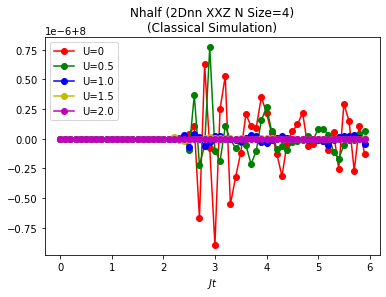

In [55]:
%matplotlib inline

N = 4 #이차원이면 N by N
U = 1.0
h = 0
draw_type = ['2Dnn', 'XXZ', 'Nhalf', 'N']
dt = 0.1
t = 6
to_image = True

if draw_type[0] == '2Dnn':
    LANDIM = 60
else:
    #LAPACK 관련 오류가 나는 경우 이 값을 줄여주세요!
    LANDIM = 30

draw(N, U, h, draw_type, dt, t, to_image)

# How to draw animations

**Execute all the cells above.**

An addition of line `ani.save("name.gif")` would save your animation into a gif file.

Configurable parameters are shown below

```
num_t = 100
t = np.linspace(0, 10, num=num_t)
```

```
E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), 50)
```

```
N = 10
U = 0
h = 1
is_disordered = True
```

<IPython.core.display.Javascript object>


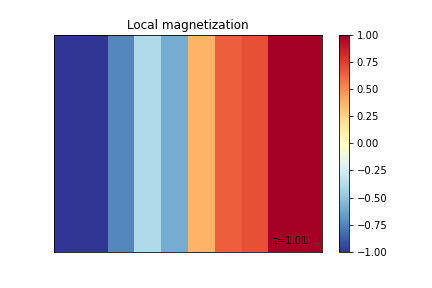

In [41]:
N = 10
U = 0
h = 1
is_disordered = True

# Initial state (domain_wall or neel)
initial_state_type = 'domain_wall'

def hamiltonian(x):
    return apply_hamiltonian(x, N, U, h, is_disordered)
    
H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
psi_zero = get_psi_zero(N, initial_state_type)

num_t = 100
t = np.linspace(0, 10, num=num_t)
E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), 100)
sig_z_result = []
for time in t:
    for i in range(N):
        sig_z_result.append(meas_sig_z(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1), i))
        
sig_z_array = np.reshape(sig_z_result, (num_t, N))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, ax = plt.subplots()
ax.set_xlim(-0.5, N-.5)
a = sig_z_array[0].reshape([1, -1])
im = plt.imshow(a, cmap='RdYlBu_r', origin='lower', vmin=-1, vmax=1, interpolation='nearest', aspect='auto')
text = plt.text(0.95, 0.05,f't={t[0]}',
                horizontalalignment='right',
                verticalalignment='center',
                transform = ax.transAxes)
plt.colorbar()
plt.xticks([])
plt.yticks([])

def animate(i):
    a = sig_z_array[i].reshape([1, -1])
    im.set_array(a)
    text.set_text(f't={"{0:.2f}".format(t[i])}')
    im.set_array(a)
    return [im]

ani = FuncAnimation(fig, animate, frames=num_t)
plt.title("Local magnetization")
plt.show()

<IPython.core.display.Javascript object>


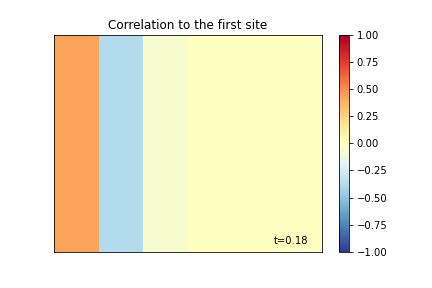

In [56]:
N = 6
U = 0
h = 0
is_disordered = False

# Initial state (domain_wall or neel)
initial_state_type = 'neel'

def hamiltonian(x):
    return apply_hamiltonian(x, N, U, h, is_disordered)
    
H = LinearOperator((2**N, 2**N), matvec=hamiltonian)
psi_zero = get_psi_zero(N, initial_state_type)

num_t = 100
t = np.linspace(0, 3, num=num_t)
E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**N), 60)
cor_result = []
for time in t:
    for i in range(N):
        cor_result.append(meas_cor(N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**N, 1), i))
        
cor_array = np.reshape(cor_result, (num_t, N))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, ax = plt.subplots()
ax.set_xlim(-0.5, N-.5)
a = cor_array[0].reshape([1, -1])
im = plt.imshow(a, cmap='RdYlBu_r', origin='lower', vmin=-1, vmax=1, interpolation='nearest', aspect='auto')
text = plt.text(0.95, 0.05,f't={t[0]}',
                horizontalalignment='right',
                verticalalignment='center',
                transform = ax.transAxes)
plt.colorbar()
plt.xticks([])
plt.yticks([])

def animate(i):
    a = cor_array[i].reshape([1, -1])
    text.set_text(f't={"{0:.2f}".format(t[i])}')
    im.set_array(a)
    return [im]

ani = FuncAnimation(fig, animate, frames=num_t)
plt.title("Correlation to the first site")
plt.show()

<IPython.core.display.Javascript object>


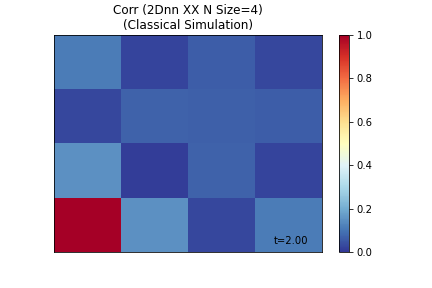

MovieWriter ffmpeg unavailable; using Pillow instead.


In [63]:
N = 4 # number of columns
M = 4 # number of rows
U = 0
h = 0
is_disordered = False

# Initial state (domain_wall or neel)
initial_state_type = 'neel'

def hamiltonian_2D(x):
    return apply_2D_hamiltonian(x, M, N, U, h, is_disordered)
    
H = LinearOperator((2**(M*N), 2**(M*N)), matvec=hamiltonian_2D)
psi_zero = get_2D_psi_zero(M, N, initial_state_type)

num_t = 61
t = np.arange(0, 6.1, 0.1)
E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**(N*M)), 50)
sig_z_result = []
for time in t:
    for j in range(M):
        for i in range(N):
            sig_z_result.append(meas_2D_cor(M, N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**(N*M), 1), j, i))
        
sig_z_array = np.reshape(sig_z_result, (num_t, M, N))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, ax = plt.subplots()
a = sig_z_array[0].reshape([M, N])
im = plt.imshow(a, cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks([])
plt.yticks([])
text = plt.text(0.95, 0.05,f't={t[0]}',
                horizontalalignment='right',
                verticalalignment='center',
                transform = ax.transAxes)

def animate(i):
    a = sig_z_array[i].reshape([M, N])
    im.set_array(a)
    text.set_text(f't={"{0:.2f}".format(t[i])}')
    return [im]

ani = FuncAnimation(fig, animate, frames=num_t)
plt.title("Corr (2Dnn XX N Size=4)\n(Classical Simulation)")
plt.show()
ani.save("Classic_Corr.gif")

<IPython.core.display.Javascript object>


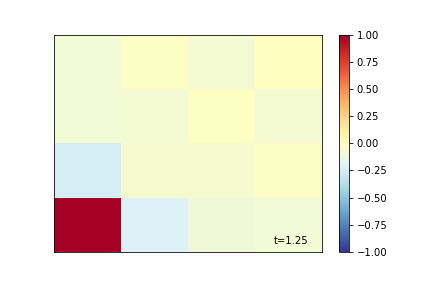

In [26]:
N = 4 # number of columns
M = 4 # number of rows
U = 0
h = 1
is_disordered = True

# Initial state (domain_wall or neel)
initial_state_type = 'neel'

def hamiltonian_2D(x):
    return apply_2D_hamiltonian(x, M, N, U, h, is_disordered)
    
H = LinearOperator((2**(M*N), 2**(M*N)), matvec=hamiltonian_2D)
psi_zero = get_2D_psi_zero(M, N, initial_state_type)

num_t = 100
t = np.linspace(0, 2, num=num_t)
E, V, Q_T = lancozs.lanczos_full(H, psi_zero.reshape(2**(N*M)), 50)
cor_result = []
for time in t:
    for j in range(M):
        for i in range(N):
            cor_result.append(meas_2D_cor(M, N, lancozs.expm_lanczos(E,V,Q_T,a=-1.j *  time).reshape(2**(N*M), 1), j, i))
        
cor_array = np.reshape(cor_result, (num_t, M, N))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, ax = plt.subplots()
a = cor_array[0].reshape([M, N])
im = plt.imshow(a, cmap='RdYlBu_r', origin='lower', vmin=-1, vmax=1, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks([])
plt.yticks([])
text = plt.text(0.95, 0.05,f't={t[0]}',
                horizontalalignment='right',
                verticalalignment='center',
                transform = ax.transAxes)

def animate(i):
    a = cor_array[i].reshape([M, N])
    im.set_array(a)
    text.set_text(f't={"{0:.2f}".format(t[i])}')
    return [im]


ani = FuncAnimation(fig, animate, frames=num_t)
plt.title("Correlation to the first site")
plt.show()